<center><img src='./img/cs-logo.png' width=200></center>

<hr style=" border:none; height:3px;">
<h1>
<center>Influence Maximisation - LT and IC Models </center>
</h1>
<font  size="3" color='#91053d'>
<center >
nacera.seghouani@centralesupelec.fr 
</center>
</font>   
<hr style=" border:none; height:3px;">

#####  Introduction (PLEASE READ ME)


<p align="justify">
<font size="3">
The purpose of this lab is to implement diffusion models   basic **Linear Threshold (LT)** and  **Independant Cascade (IC)** models using networkx Python package. The graph could be weighted  using for each edge (u,v) 1/d_v as a weight or For nodes u,v, u has a total probability of 1 − (1 −p) of activating v (for p = 1% and 10%). More precisely:
<ol>
<li>Implement two functions ic and lt where the inputs are (G, S) and the output is the set of infected nodes.  </li>
<li> S (budget k) could be computed randomly, using the highest degrees,  and other measures such as betweeness centrality. Compare the different heuristics  results on some graphs (curves according to the number of iteration a  </li>
<li> Implement Greedy algorithm and compare the results on graphs to the different heuristics</li> 
</ol>
</font>
</p>




In [1]:
#import libraries
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import random
from random import randint
import matplotlib.animation as animation
from matplotlib import rc, rcParams

rc('animation', html='jshtml')
rcParams['axes.facecolor'] = 'white'

In [2]:
def IndependantCascade(G: nx.Graph, seeds: list, activation_prob: float = 0.5):
    """Independant Cascade

    Given a graph G, a set of intial seeds, and activation probability of  
    a node by a neighbor, return result of the Independant Cascade model, 
    including the infected nodes and infection_log which is the infected 
    nodes at each iteration. The first element of infection_log is the seeds.
    
    """
    if len(seeds) == 0 or len(G) == 0:
        return [], []
    assert type(seeds[0]) == type(list(G)[0]), 'seeds must be the same type as graph nodes'

    infected_nodes = seeds.copy()
    uninfected_nodes = [n for n in list(G) if n not in infected_nodes]
    # record the edge that can't be use for activation again
    # only need to record when activation fails
    used_edges = list()  

    infection_log = list()
    infection_log.append(infected_nodes.copy())
    
    while True:
        infected_by_step = list()
        activate_any = False
        new_uninfected_nodes = uninfected_nodes[:]
        for node in uninfected_nodes:
            activated_neighbors = [ne for ne in G.neighbors(node) if ne in infected_nodes]
            valid_neighbors = [ne for ne in activated_neighbors if (ne, node) not in used_edges]
            if len(valid_neighbors) == 0:
                continue
            prob = 1 - (1-activation_prob) ** len(valid_neighbors)
            random.seed(100)
            ran = random.random()
            if ran <= prob:
                # Activation succeeds
                activate_any = True
                infected_by_step.append(node)
                infected_nodes.append(node)
                new_uninfected_nodes.remove(node)
            else:
                used_edges += [(ne, node) for ne in valid_neighbors]
        if not activate_any:
            break
        uninfected_nodes = new_uninfected_nodes
        infection_log.append(infected_by_step)
    return infected_nodes, infection_log

In [3]:
def draw_influence_graph(G, pos, infected_nodes=[], ax=None, **kwds):
    color_map = ['#1f78b4' if n not in infected_nodes else '#ff2638' for n in list(G)]
    nx.draw_networkx(G, pos=pos, ax=ax, node_color = color_map, **kwds)

def get_slide_show_infection_process(G, infection_log, pos=None, interval=400, **kwds):
    fig, ax = plt.subplots(figsize=(15,10))
    artists = list()
    infected_so_far = list()
    track = []
    for step in infection_log:
        infected_so_far += step
        draw_influence_graph(G, pos, infected_so_far, ax, **kwds)
        art = ax.get_children()
        # print(art)
        artists.append([a for a in art if a not in track])
        track += art
    anim = animation.ArtistAnimation(fig, artists, interval=interval, repeat_delay=1000, blit=True)
    plt.close()
    return anim

Text(0.5, 1.0, 'Initial Graph')

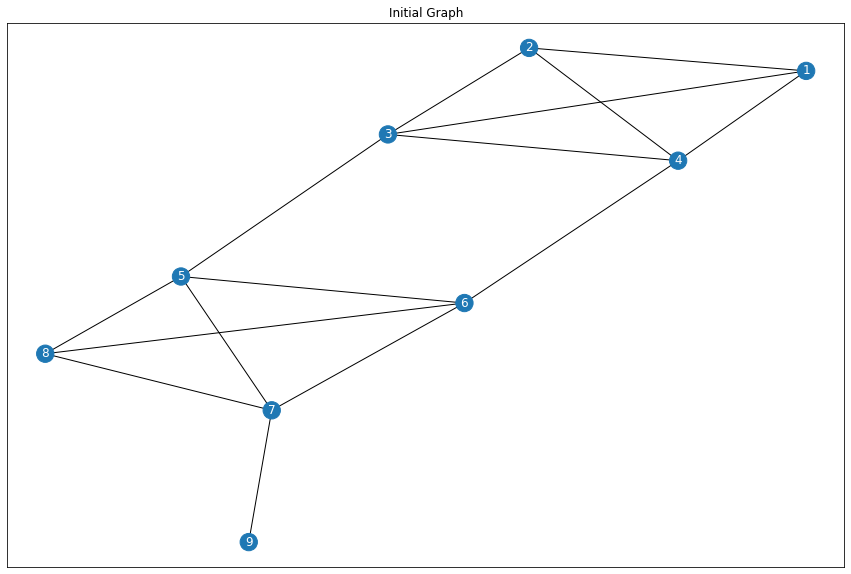

In [4]:
G0 = nx.read_edgelist('./data/simple_graph.edgelist')
plot_options = {
    "with_labels" : True, 
    "font_color" : 'w',
}
pos = nx.spring_layout(G0, seed=100)
fig, ax = plt.subplots(figsize=(15,10))
draw_influence_graph(G0, pos=pos, ax=ax, **plot_options)
plt.gca().set_title('Initial Graph')

In [5]:
seeds = ['6','7']
infected_nodes, infection_log = IndependantCascade(G0, seeds=seeds, activation_prob=0.1)
print('infected_nodes', infected_nodes)
print('infection log by steps', infection_log)
anim = get_slide_show_infection_process(G0, infection_log, pos=pos, **plot_options)
anim

infected_nodes ['6', '7', '5', '8']
infection log by steps [['6', '7'], ['5', '8']]


In [6]:
#read the datasets
facebook = pd.read_csv(
    "data/facebook_combined.txt.gz",
    compression="gzip",
    sep=" ",
    names=["start_node", "end_node"],
)
facebook

start_node  end_node
0               0         1
1               0         2
2               0         3
3               0         4
4               0         5
...           ...       ...
88229        4026      4030
88230        4027      4031
88231        4027      4032
88232        4027      4038
88233        4031      4038

[88234 rows x 2 columns]

In [7]:
#create a graph
G = nx.from_pandas_edgelist(facebook, "start_node", "end_node")
print('nodes:', len(G.nodes))
print('edges:', len(G.edges))

nodes: 4039
edges: 88234


In [8]:
import random
random.seed(100)
nodes = random.sample(list(G), k=800)
G1 = G.subgraph(nodes)
Gcc = sorted(nx.connected_components(G1), key=len, reverse=True)
G1 = G1.subgraph(Gcc[0])
print('nodes:', len(G1.nodes))
print('edges:', len(G1.edges))

nodes: 533
edges: 3066


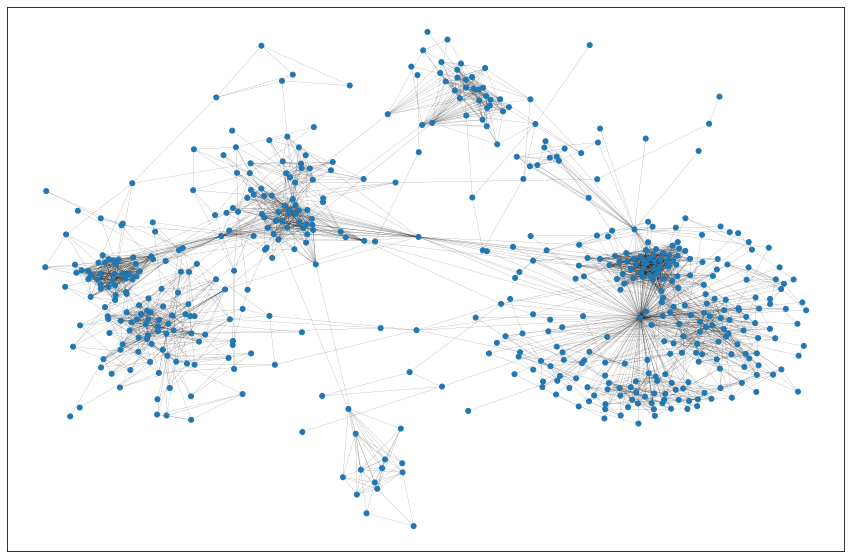

In [9]:
pos = nx.spring_layout(G1, k=0.18, seed=3)
fig, ax = plt.subplots(figsize=(15,10))

plot_options = {
    "node_size": 25, 
    "with_labels": False, 
    "width": 0.10,
}
draw_influence_graph(G1, pos=pos, ax=ax, **plot_options)


In [10]:

# print('diameter:', nx.diameter(G1))
print('highest degree:', max(G1.degree, key=lambda t: t[1])[1])

activation_prob = 0.05

budget = int(len(list(G1)) * 0.05)
print("initial seeds size:", budget)

highest degree: 205
initial seeds size: 26


In [11]:
# Test1: randomize
seeds = random.sample(list(G1), k=budget)
infected_nodes1, infection_log1 = IndependantCascade(G1, seeds=seeds, activation_prob=activation_prob)

print('infected_nodes num:', len(infected_nodes1))
print(f'infected_nodes percentage: {len(infected_nodes1)/len(G1.nodes)}', )
print('infection steps:', len(infection_log1))

anim = get_slide_show_infection_process(G1, infection_log1, pos=pos, **plot_options)

with open('./anim/anim1.html', 'w') as f:
    f.write( anim.to_jshtml())

anim

infected_nodes num: 43
infected_nodes percentage: 0.08067542213883677
infection steps: 2


In [12]:
# Test2: top degree
degree_rank = sorted(G1.degree, key=lambda x: x[1], reverse=True)
seeds = [tu[0] for tu in degree_rank[:budget]]
infected_nodes2, infection_log2 = IndependantCascade(G1, seeds=seeds, activation_prob=activation_prob)

print('infected_nodes num:', len(infected_nodes2))
print(f'infected_nodes percentage: {len(infected_nodes2)/len(G1.nodes)}', )
print('infection steps:', len(infection_log2))

anim = get_slide_show_infection_process(G1, infection_log2, pos=pos, **plot_options)

with open('./anim/anim2.html', 'w') as f:
    f.write( anim.to_jshtml())

anim

infected_nodes num: 160
infected_nodes percentage: 0.300187617260788
infection steps: 3


In [13]:
# Test3: betweeness centrality 
bc_rank = sorted(list(nx.betweenness_centrality(G1).items()), key=lambda x: x[1], reverse=True)
seeds = [tu[0] for tu in bc_rank[:budget]]
infected_nodes3, infection_log3 = IndependantCascade(G1, seeds=seeds, activation_prob=activation_prob)

print('infected_nodes num:', len(infected_nodes3))
print(f'infected_nodes percentage: {len(infected_nodes3)/len(G1.nodes)}', )
print('infection steps:', len(infection_log3))


anim = get_slide_show_infection_process(G1, infection_log3, pos=pos, **plot_options)

with open('./anim/anim3.html', 'w') as f:
    f.write( anim.to_jshtml())

anim

infected_nodes num: 96
infected_nodes percentage: 0.1801125703564728
infection steps: 4


In [14]:
# Test4: community detection 

communities_generator = community.girvan_newman(G1)
top_level_communities = next(communities_generator)

next_level_communities = next(communities_generator)
next_level_communities = next(communities_generator)
print("third_level_communities:", len(next_level_communities))


third_level_communities: 4


In [15]:
com_num = len(next_level_communities)
sub_budgets = []
for i in range(com_num-1):
    sub_budgets.append(int(budget * (len(next_level_communities[i])/len(G1.nodes))))
sub_budgets.append(budget-sum(sub_budgets))
print('communities size', [len(c) for c in next_level_communities])
print('seeds distribution', sub_budgets)

seeds = []
for i in range(com_num):
    sub_degree_rank = [tu for tu in degree_rank if tu[0] in next_level_communities[i]]
    sub_budget = sub_budgets[i]
    sub_seeds  = [tu[0] for tu in sub_degree_rank[:sub_budget]]
    seeds += sub_seeds

infected_nodes4, infection_log4 = IndependantCascade(G1, seeds=seeds, activation_prob=activation_prob)

print('infected_nodes num:', len(infected_nodes4))
print(f'infected_nodes percentage: {len(infected_nodes4)/len(G1.nodes)}', )
print('infection steps:', len(infection_log4))


anim = get_slide_show_infection_process(G1, infection_log4, pos=pos, **plot_options)

with open('./anim/anim4.html', 'w') as f:
    f.write( anim.to_jshtml())

anim

communities size [138, 260, 94, 41]
seeds distribution [6, 12, 4, 4]
infected_nodes num: 181
infected_nodes percentage: 0.3395872420262664
infection steps: 3


In [27]:
# Test5: greedy algorithm

# Here we use the precomputed seeds by the following codes
# from models import greedy_seeds
# seeds = greedy_seeds(G1, budget, IndependantCascade, activation_prob = activation_prob)

seeds = [2056,2067,2068,2075,2076,2081,1970,2312,2084,2088,58,2113,2120,2126,2205,2618,2130,2146,2238,2497,107,2175,2193,2217,2255,2284]

infected_nodes5, infection_log5 = IndependantCascade(G1, seeds=seeds, activation_prob=activation_prob)

print('infected_nodes num:', len(infected_nodes5))
print(f'infected_nodes percentage: {len(infected_nodes5)/len(G1.nodes)}', )
print('infection steps:', len(infection_log5))


anim = get_slide_show_infection_process(G1, infection_log5, pos=pos, **plot_options)

with open('./anim/anim5.html', 'w') as f:
    f.write( anim.to_jshtml())

anim

infected_nodes num: 109
infected_nodes percentage: 0.2045028142589118
infection steps: 3


Text(0.5, 1.0, 'Comparison of different seeds initialization')

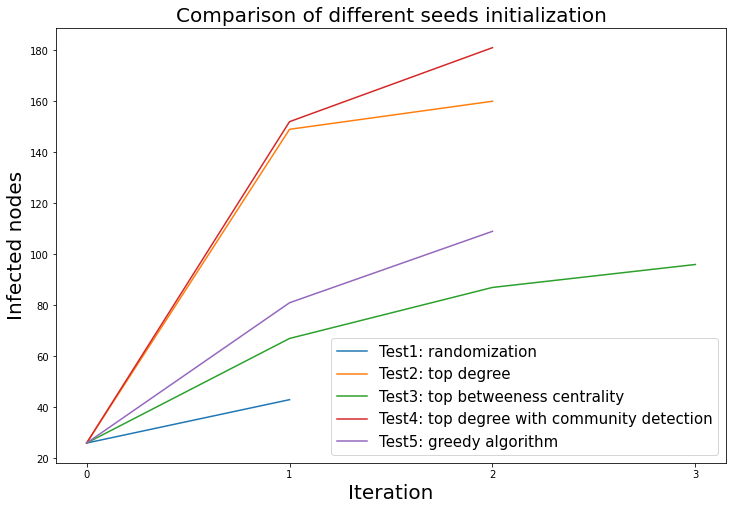

In [28]:
# Compare the tests
from matplotlib.ticker import MaxNLocator

def infected_by_step(infection_log):
    arr = [0]
    for step in infection_log:
        new_infected_num = len(step)
        arr.append(new_infected_num + arr[-1])
    arr = arr[1:]
    return arr

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(infected_by_step(infection_log1), label='Test1: randomization')
ax.plot(infected_by_step(infection_log2), label='Test2: top degree')
ax.plot(infected_by_step(infection_log3), label='Test3: top betweeness centrality')
ax.plot(infected_by_step(infection_log4), label='Test4: top degree with community detection')
ax.plot(infected_by_step(infection_log5), label='Test5: greedy algorithm')
plt.legend(loc=4, prop={'size': 15})
plt.xlabel("Iteration", fontsize=20)
plt.ylabel("Infected nodes", fontsize=20)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title("Comparison of different seeds initialization", fontsize=20)